# Multiprocessing

In the following block, a thread pool executor is created. Each thread in that pool acts as a "process manager". In other words, each thread spawns a new process (which is might be scheduled on another CPU core, enhancing performance), and checks if they are finished after `TIMEOUT` or not; if not, then they termiante the process, otherwise they fetch the function's return value (which is serialized into a file) and return it as a result. In case of process being timed out, another function (`timeout_handler`) is called.

In [1]:
import multiprocess as mp
import os
import dill
from concurrent.futures.thread import ThreadPoolExecutor
from uuid import uuid4

TIMEOUT = 12 * 60 # 10 Minutes
WORKERS_COUNT = 8 # Running 8 process simultanously

def capture_output(fname, func, *args):
    result = func(*args)
    with open(fname, "wb") as f:
        import dill
        dill.dump(result, f)

def handler_with_timeout(args):
    func, fn_args, timeout, timeout_callback = args[:4]
    fname= f"{str(uuid4())}.dill"

    p = mp.Process(target=capture_output, args=(fname, func, *fn_args,))
    p.start()
    p.join(timeout=timeout)
    if p.exitcode != 0:
        p.terminate()
        try:
            os.remove(fname)
        except:
            pass
        return timeout_callback(*fn_args)
    
    with open(fname, "rb") as f:
        result = dill.load(f)

    os.remove(fname)
    return result

def timeout_handler(algorithm, case, result_cls):
    return result_cls(case, algorithm)

thread_pool = ThreadPoolExecutor(WORKERS_COUNT)

# Initialize Test Cases
In following block(s), I am going to create test cases that are going to be used to test algorithms with. If there exists previous test cases, it loads them.

In [2]:
from networkx.generators.community import LFR_benchmark_graph
import dill


class Scenario:
    n = None
    tau1 = None # Parameter for degree distribution, > 1
    tau2 = None # Parameter for community size distribution, > 1
    mu = None # Fraction of inter-community edges, 0 <= mu <= 1
    average_degree = None

    def __init__(self, n, tau1, tau2, mu, average_degree) -> None:
        self.n = n

        assert tau1 > 1
        self.tau1 = tau1
        
        assert tau2 > 1
        self.tau2 = tau2
        
        assert 0 <= mu and mu <= 1
        self.mu = mu
        
        self.average_degree = average_degree
        
    def __str__(self):
        return f"{self.n}_{self.tau1}_{self.tau2}_{self.mu}_{self.average_degree}"

class TestCase:
    params = None
    test_number=0
    generation_time=0
    networkx_G=None
    igraph_G=None
    communities=None
    
    def __init__(self, scenario, test_number):
        self.params = scenario
        self.test_number = test_number

T = 5
I = 4 * T

scenarios = [ # Scenarios for LFR benchmark graphs generation
    Scenario(1000, 2, 1.1, 0.5, 10),
    Scenario(1000, 2, 1.1, 0.5, 15),
    Scenario(1000, 2, 1.1, 0.5, 20),
    
    Scenario(1000, 2, 1.1, 0.2, 10),
    Scenario(1000, 2, 1.1, 0.35, 10),
    Scenario(1000, 2, 1.1, 0.65, 10),
    Scenario(1000, 2, 1.1, 0.80, 10),

    Scenario(2000, 2, 1.1, 0.5, 10),
    Scenario(3000, 2, 1.1, 0.5, 10),
    Scenario(4000, 2, 1.1, 0.5, 10),
    
    Scenario(10000, 2, 1.1, 0.5, 10),
    Scenario(50000, 2, 1.1, 0.5, 10),
]

def generate_case(s, t, case_cls):
    from time import time
    from networkx.generators.community import LFR_benchmark_graph
    from igraph import Graph
    test_case = case_cls(s, t)
    
    t0 = time()
    # try:
    g = LFR_benchmark_graph(**s.__dict__, seed=int(t0 * (t+1)), max_iters=1000)
    test_case.networkx_G = g
    test_case.igraph_G = Graph.from_networkx(g)
    
    t1 = time()
    test_case.generation_time = (t1 - t0)
    
    return test_case

def case_timeout_handler(s, t, case_cls):
    return case_cls(s, t)


test_cases = []
test_cases_dill = "test_cases.dill"
try:
    with open(test_cases_dill, "rb") as f:
        test_cases = dill.load(f)
except:
    pass


# TIMEOUT = 5 * 60

# test_generation_inp = [(s, t, TestCase) for s in scenarios for t in range(I)]
# args = [(generate_case, inp, TIMEOUT, case_timeout_handler) for inp in test_generation_inp]

# for result in thread_pool.map(handler_with_timeout, args):
#     test_cases.append(result)  

Dumping test cases for future use:

In [10]:
with open(test_cases_dill, "wb") as f:
    dill.dump(test_cases, f)

In the following cells, as this code have generated more cases than needed, and in some cases the algorithm did not ended (did not generated a graph), I selected only `T` cases for each scenario.

In [3]:
scenario_cases = {}
final_cases = []

def calculate_partitions(G):
    partitions = {}
    for node in G.nodes:
        if node in partitions:
            continue
        partitions[node] = node
        for adj in G.nodes[node]['community']:
            partitions[adj] = node

    community_id = [(node, partitions[node]) for node in partitions]
    community_id = sorted(community_id)
    return [community for _, community in community_id]

for i, case in enumerate(test_cases):
    if case.networkx_G is None:
        continue
        
    key = str(case.params)
    if key not in scenario_cases:
        scenario_cases[key] = []
    
    scenario_cases[key].append(case)
    
for s in scenario_cases:
    print(s, ":\t", len(scenario_cases[s]))
    
    for case in scenario_cases[s][:T]:
        case.communities = calculate_partitions(case.networkx_G)
        final_cases.append(case)

print(len(final_cases))

1000_2_1.1_0.5_10 :	 12
1000_2_1.1_0.5_15 :	 6
1000_2_1.1_0.5_20 :	 7
1000_2_1.1_0.2_10 :	 1
1000_2_1.1_0.35_10 :	 8
1000_2_1.1_0.65_10 :	 10
1000_2_1.1_0.8_10 :	 11
2000_2_1.1_0.5_10 :	 10
3000_2_1.1_0.5_10 :	 12
4000_2_1.1_0.5_10 :	 7
10000_2_1.1_0.5_10 :	 15
50000_2_1.1_0.5_10 :	 9
56


# Initialize Algorithms to find communities

Here we define an `Algorithm` class that implements the corresponding algorithms, and returns a list of community ids for each node.

The following algorithms are used from already implemented libraries:
- CNM (from networkx package)
- Louvain (from igraph package)
- Leiden (from leidenalg)
- Spinglass (from igraph package)
- Leading Eigenvector (from igraph package)

In [4]:
class Algorithm:
    name=""
    MAX_N=2000
    
    def find_communities(self, case):
        return []

    
class CNM(Algorithm):
    name = "CNM"
    MAX_N = 10000

    def convert_sets_to_nodes_list(self, communities):
        community_id = []
        
        for i, community in enumerate(communities):
            for node in community:
                community_id.append((node, i))
        community_id = sorted(community_id)
        return [community for _, community in community_id]
    
    def find_communities(self, case):
        from networkx.algorithms.community.modularity_max import greedy_modularity_communities
        g = case.networkx_G
        communities = list(greedy_modularity_communities(g))
        return self.convert_sets_to_nodes_list(communities)

    
class Louvain(Algorithm):
    name = "Louvain"
    MAX_N=50000

    def find_communities(self, case):
        return case.igraph_G.community_multilevel().membership


class Leiden(Algorithm):
    name = "Leiden"
    MAX_N=50000

    def find_communities(self, case):
        import leidenalg as la
        return la.find_partition(case.igraph_G, la.ModularityVertexPartition).membership


class SimulatedAnnealing(Algorithm):
    name = "SimulatedAnnealing"

    def find_communities(self, case):
        return case.igraph_G.community_spinglass().membership

class EigenVector(Algorithm):
    name = "EigenVector"
    MAX_N=50000

    def find_communities(self, case):
        return case.igraph_G.community_leading_eigenvector().membership


Additionally, a genetic algorithm has been implemented. This implementation is inspired by the Liu et al (2017) and Pizzuti (2008). The trick here is to optimize the initial population by moving a vertex out of community if it has no strong connection with the other vertices in that community.

In [5]:
class GeneticAlg(Algorithm):
    name = "GeneticAlgorithm"
    class Gene:
        def __init__(self) -> None:
            self.membership = []
            self.S = []
            self.fitness = 0

        def _calculate_fitness(self, G):
            from networkx.algorithms.community.quality import modularity
            c = {}
            for u, comm in enumerate(self.membership):
                if comm not in c:
                    c[comm] = set()
                
                c[comm].add(u)

            comms = []
            for key in c:
                comms.append(c[key])
            self.fitness = modularity(G, comms)

    def __init__(self, num_generation, num_population, t_size, num_elites) -> None:
        self.num_generation = num_generation
        self.T_size = t_size
        self.num_elites = num_elites
        self.pop_size = num_population

    def _initialize_population(self, G, num):
        import math
        k = int(math.sqrt(G.number_of_nodes())) + 1
        population = []
        for _ in range(num):
            gene = self._generate_gene(G, k)
            gene = self._repaired(G, gene)
            population.append(gene)
        
        return population

    def _repaired(self, G, gene):
        comms = {}
        for u, i in enumerate(gene.membership):
            if i not in comms:
                comms[i] = set()

            comms[i].add(u)

        for c in comms:
            for u in comms[c]:
                n_u_not_in_c = set()
                for v in G.neighbors(u):
                    if gene.membership[v] != gene.membership[u]:
                        n_u_not_in_c.add(v)
                for v in comms[c]:
                    if G.has_edge(u, v):
                        continue
                    if len(n_u_not_in_c) == 0:
                        break
                    w = n_u_not_in_c.pop()
                    gene.membership[v], gene.membership[w] = gene.membership[w], gene.membership[v]

        return gene

    def _generate_gene(self, G, k):
        n = G.number_of_nodes()
        gene = self.Gene()

        from numpy.random import randint
        membership = []

        for _ in range(n):
            comm = randint(0, k)
            membership.append(comm)
        
        gene.membership = membership
        gene._calculate_fitness(G)
        
        return gene

    def find_communities(self, case):
        G = case.networkx_G
        mu = 1/(1 + G.number_of_nodes())

        population = self._initialize_population(G, self.pop_size)
        population = sorted(population, key=lambda x: -x.fitness)
        fittest = population[0]

        fs = []
        from tqdm import tqdm
        for _ in tqdm(range(self.num_generation)):
            population = self.iterate(population, G, mu)
            fittest = population[0]
            fs.append(fittest.fitness)

        import matplotlib.pyplot as plt
        import numpy as np
        plt.plot(np.arange(1, self.num_generation+1), fs)
        plt.xlabel("Generation")
        plt.ylabel("Best Solution in Generation")
        plt.show()
        return fittest.membership

    def iterate(self, last_pop, G, mu):
        from numpy.random import rand
        gen_children = []
        for _ in range(self.pop_size):
            par1, par2 = self.select_parents(last_pop)
            children = self.crossover(par1, par2)
            for child in children:
                gen_children.append(child)


        for partition in last_pop + gen_children:
            if rand() <= mu:
                partition = self.mutate(G, partition)

            partition._calculate_fitness(G)

        last_pop = sorted(last_pop, key=lambda x: -x.fitness)
        gen_children = sorted(gen_children, key=lambda x: -x.fitness)

        # Keep elites from last generation
        new_population = last_pop[: self.num_elites]
        n = min(self.pop_size - self.num_elites, len(gen_children))
        new_population += gen_children[:n]

        new_population = sorted(new_population, key=lambda x: -x.fitness)

        return new_population

    def select_parents(self, pop):
        from numpy.random import choice
        tournament = choice(pop, size=self.T_size)
        tournament = sorted(tournament, key=lambda x: -x.fitness)

        return (tournament[0], tournament[1])

    def crossover(self, par1, par2):
        from numpy.random import randint

        n = len(par1.membership)
        child1 = self.Gene()
        child1.membership = par1.membership.copy()
        pos1 = randint(0, n)
        child1.membership[pos1] = par2.membership[pos1]


        child2 = self.Gene()
        child2.membership = par2.membership.copy()
        pos2 = randint(0, n)
        child2.membership[pos2] = par1.membership[pos2]

        return (child1, child2)

    def mutate(self, G, partition):
        from numpy.random import randint

        n = len(partition.membership)
        pos = randint(0, n)
        available_options = [neighbor for neighbor in G.neighbors(pos)]
        partition.membership[pos] = available_options[randint(0, len(available_options))]

        return partition

# Initialize Solver

`solve` functions couples the algorithm and test case, then executes the algorithm and returns its results, alongside its performance metrics.

In [6]:


class Result:
    communities=None
    computation_time=None
    modularity=None
    nmi=None
    case=None
    algorithm=None

    def __init__(self, case, algorithm):
        self.case = case
        self.algorithm = algorithm


def solve(algorithm, case, result_cls):
    from sklearn.metrics import normalized_mutual_info_score
    from time import time
    
    result = result_cls(case, algorithm)
    t0 = time()

    communities = algorithm.find_communities(case)

    t1 = time()

    result.communities = communities
    result.computation_time = t1 - t0
    result.modularity = case.igraph_G.modularity(communities)
    result.nmi = normalized_mutual_info_score(case.communities, communities)

    return result



For efficiency and utilization reseans, we need to run our processes on multiple cpu cores (since python uses only one core by default). In fact, as our tasks are computation intensive, we run them simaltunasely to save time.

In [7]:
TIMEOUT = 15 * 60

algorithms = [CNM(), Louvain(), Leiden(), SimulatedAnnealing(), EigenVector(), GeneticAlg(50, 100, 20, 15)]
solve_inputs = [(algorithm, case, Result) for algorithm in algorithms for case in final_cases[:]]
args = [(solve, inp, TIMEOUT, timeout_handler) for inp in solve_inputs]

results = []

for result in thread_pool.map(handler_with_timeout, args):
    results.append(result)


In [30]:
sum([res.nmi is None for res in results])/len(results)

0.13392857142857142

In [9]:
import dill

with open("result.dill", "wb") as f:
    dill.dump(results, f)
    

In [10]:
nones = []
for res in results:
    if res.nmi is None:
        nones.append((res.algorithm.name, str(res.case.params)))

nones

[('CNM', '10000_2_1.1_0.5_10'),
 ('CNM', '10000_2_1.1_0.5_10'),
 ('CNM', '10000_2_1.1_0.5_10'),
 ('CNM', '50000_2_1.1_0.5_10'),
 ('CNM', '50000_2_1.1_0.5_10'),
 ('CNM', '50000_2_1.1_0.5_10'),
 ('CNM', '50000_2_1.1_0.5_10'),
 ('CNM', '50000_2_1.1_0.5_10'),
 ('SimulatedAnnealing', '2000_2_1.1_0.5_10'),
 ('SimulatedAnnealing', '10000_2_1.1_0.5_10'),
 ('SimulatedAnnealing', '10000_2_1.1_0.5_10'),
 ('SimulatedAnnealing', '10000_2_1.1_0.5_10'),
 ('SimulatedAnnealing', '10000_2_1.1_0.5_10'),
 ('SimulatedAnnealing', '10000_2_1.1_0.5_10'),
 ('SimulatedAnnealing', '50000_2_1.1_0.5_10'),
 ('SimulatedAnnealing', '50000_2_1.1_0.5_10'),
 ('SimulatedAnnealing', '50000_2_1.1_0.5_10'),
 ('SimulatedAnnealing', '50000_2_1.1_0.5_10'),
 ('SimulatedAnnealing', '50000_2_1.1_0.5_10'),
 ('EigenVector', '1000_2_1.1_0.5_15'),
 ('GeneticAlgorithm', '1000_2_1.1_0.5_20'),
 ('GeneticAlgorithm', '2000_2_1.1_0.5_10'),
 ('GeneticAlgorithm', '2000_2_1.1_0.5_10'),
 ('GeneticAlgorithm', '2000_2_1.1_0.5_10'),
 ('GeneticAlg

# Generating Report

## Tables

In [42]:
def calculate_modularity(G, membership):
    from networkx.algorithms.community.quality import modularity
    c = {}
    for u, comm in enumerate(membership):
        if comm not in c:
            c[comm] = set()

        c[comm].add(u)

    comms = []
    for key in c:
        comms.append(c[key])
    return modularity(G, comms)


tbl1 = {}        

for res in results:
    alg = res.algorithm.name
    if alg not in tbl1:
        tbl1[alg] = {}
    
    case = res.case
    if case.params.n != 1000 or case.params.average_degree != 10:
        continue
    
    case_str = str(case.params)
    if case_str not in tbl1[alg]:
        tbl1[alg][case_str] = []
        
    tbl1[alg][case_str].append(res)

for alg in tbl1:
    print(alg)
    for case in tbl1[alg]:
        print(f"\t{str(case)}")
        tbar = 0
        qbar = 0
        rqbar = 0
        for res in tbl1[alg][case]:
            tbar += res.computation_time
            qbar += res.modularity
            rqbar += calculate_modularity(res.case.networkx_G, res.case.communities)
        
        print(f"\tn = {len(tbl1[alg][case])}, q = {rqbar / len(tbl1[alg][case])}")
        print(f"\t\t n = {len(tbl1[alg][case])}")
        print(f"\t\t q = {qbar/len(tbl1[alg][case])}")
        print(f"\t\t t = {tbar / len(tbl1[alg][case])}")

CNM
	1000_2_1.1_0.5_10
	n = 5, q = 0.11503484669091184
		 n = 5
		 q = 0.2182308049916374
		 t = 15.270354413986206
	1000_2_1.1_0.2_10
	n = 1, q = 0.191014944565924
		 n = 1
		 q = 0.20372092372057188
		 t = 21.57857370376587
	1000_2_1.1_0.35_10
	n = 5, q = 0.3155477719711063
		 n = 5
		 q = 0.32844300603277465
		 t = 17.519592618942262
	1000_2_1.1_0.65_10
	n = 5, q = 0.0219357667144748
		 n = 5
		 q = 0.23841181699652475
		 t = 15.15808367729187
	1000_2_1.1_0.8_10
	n = 5, q = -0.043411270771782355
		 n = 5
		 q = 0.2097527909852115
		 t = 17.967797470092773
Louvain
	1000_2_1.1_0.5_10
	n = 5, q = 0.11503484669091184
		 n = 5
		 q = 0.21581168703541215
		 t = 0.04481682777404785
	1000_2_1.1_0.2_10
	n = 1, q = 0.191014944565924
		 n = 1
		 q = 0.1982434346259156
		 t = 0.058000802993774414
	1000_2_1.1_0.35_10
	n = 5, q = 0.3155477719711063
		 n = 5
		 q = 0.3491895697507773
		 t = 0.04279937744140625
	1000_2_1.1_0.65_10
	n = 5, q = 0.0219357667144748
		 n = 5
		 q = 0.2325387055705365
		

In [43]:
tbl2 = {}    

for res in results:
    alg = res.algorithm.name
    if alg not in tbl2:
        tbl2[alg] = {}
    
    if res.nmi is None:
        continue
        
    case = res.case
    case_str = str(case.params)
    
    if case.params.n == 1000:
        continue
#     print(case_str)
    case_str = str(case.params)
    if case_str not in tbl2[alg]:
        tbl2[alg][case_str] = []
        
    tbl2[alg][case_str].append(res)


    
for alg in tbl2:
    print(alg)
    for case in tbl2[alg]:
        print(f"\t{str(case)}")
        tbar = 0
        qbar = 0
        rqbar = 0
        for res in tbl2[alg][case]:
            tbar += res.computation_time
            qbar += res.modularity
            rqbar += calculate_modularity(res.case.networkx_G, res.case.communities)
            
        print(f"\tn = {len(tbl2[alg][case])}, q = {rqbar / len(tbl2[alg][case])}")
        print(f"\t\t n = {len(tbl2[alg][case])}")
        print(f"\t\t q = {qbar/len(tbl2[alg][case])}")
        print(f"\t\t t = {tbar / len(tbl2[alg][case])}")

CNM
	2000_2_1.1_0.5_10
	n = 5, q = 0.1749092218103056
		 n = 5
		 q = 0.2186304321993032
		 t = 73.21415028572082
	3000_2_1.1_0.5_10
	n = 5, q = 0.13309968663696067
		 n = 5
		 q = 0.20233499778868408
		 t = 168.15063166618347
	4000_2_1.1_0.5_10
	n = 5, q = 0.18410669033343283
		 n = 5
		 q = 0.22891131614460888
		 t = 297.0483060359955
	10000_2_1.1_0.5_10
	n = 2, q = 0.2696326799997027
		 n = 2
		 q = 0.3218866993862102
		 t = 822.5798449516296
Louvain
	2000_2_1.1_0.5_10
	n = 5, q = 0.1749092218103056
		 n = 5
		 q = 0.23169718467223732
		 t = 0.09279880523681641
	3000_2_1.1_0.5_10
	n = 5, q = 0.13309968663696067
		 n = 5
		 q = 0.19687886507566116
		 t = 0.22400140762329102
	4000_2_1.1_0.5_10
	n = 5, q = 0.18410669033343283
		 n = 5
		 q = 0.2304280359040905
		 t = 0.2960239887237549
	10000_2_1.1_0.5_10
	n = 5, q = 0.21171815807575864
		 n = 5
		 q = 0.26031348733929055
		 t = 0.3207108497619629
	50000_2_1.1_0.5_10
	n = 5, q = 0.24259917210684004
		 n = 5
		 q = 0.24354083864855597
	

## Plots

### X/mu (X = nmi, Q)

<Figure size 432x288 with 0 Axes>

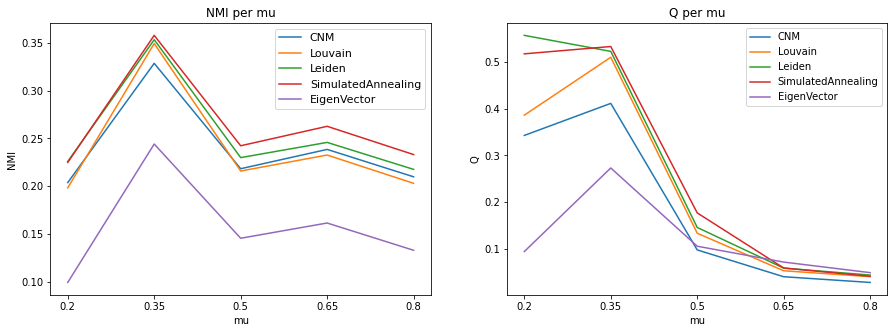

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

nmi_mu = []
q_mu =[]

base_scenarios = set()

for alg in tbl1:
    for case in tbl1[alg]:
        base_scenarios.add(case)
        
for alg in tbl1:
    if alg == "GeneticAlgorithm": # ignore GeneticAlgorithm while generating plots
        continue

    series_nmi = []
    series_q = []
    
    for case in base_scenarios:
        if case not in tbl1[alg]:
            series_nmi.append(None)
            series_q.append(None)
            continue
        qbar = 0
        nmi_bar = 0
        for res in tbl1[alg][case]:
            qbar += res.modularity
            nmi_bar += res.nmi
            
        
        series_nmi.append((case.split('_')[3], qbar/len(tbl1[alg][case])))
        series_q.append((case.split('_')[3], nmi_bar/len(tbl1[alg][case])))
    
    series_nmi = sorted(series_nmi, key=lambda x: x[0])
    series_q = sorted(series_q, key=lambda x: x[0])
    nmi_mu.append((alg, series_nmi))
    q_mu.append((alg, series_q))
        
plt.figure("Performance metrics per mu")

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

for alg, series in nmi_mu:
    ax[0].plot([x for x, y in series], [y for x, y in series], label=alg)

ax[0].legend(loc="upper right", fontsize=11)
ax[0].set_title(f"NMI per mu")
ax[0].set_xlabel("mu")
ax[0].set_ylabel("NMI")
    
for alg, series in q_mu:
    ax[1].plot([x for x, y in series], [y for x, y in series], label=alg)
    
ax[1].legend(loc="upper right")
ax[1].set_title(f"Q per mu")
ax[1].set_xlabel("mu")
ax[1].set_ylabel("Q")

plt.savefig("per-mu.png")
plt.show()
plt.close("Performance metrics per mu")

### X/N (X = nmi, Q)

<Figure size 432x288 with 0 Axes>

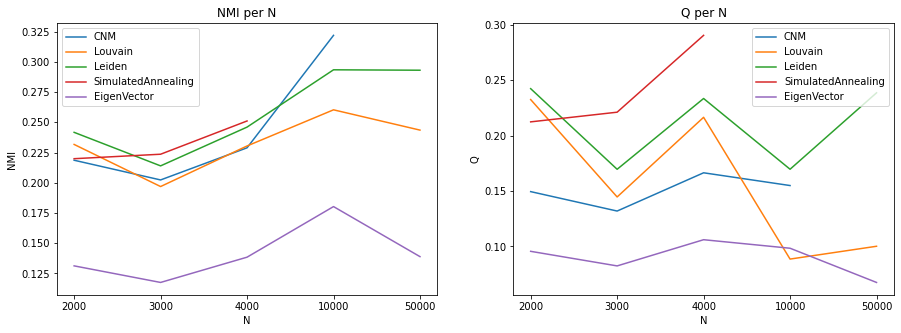

In [88]:
nmi_n = []
q_n =[]

base_scenarios = set()

for alg in tbl2:
    for case in tbl2[alg]:
        base_scenarios.add(case)
        
for alg in tbl2:
    if alg == "GeneticAlgorithm": # ignore GeneticAlgorithm while generating plots
        continue

    series_nmi = []
    series_q = []
    
    for case in base_scenarios:
        if case not in tbl2[alg]:
            series_nmi.append((case.split('_')[0], None))
            series_q.append((case.split('_')[0],None))
            continue
        qbar = 0
        nmi_bar = 0
        for res in tbl2[alg][case]:
            qbar += res.modularity
            nmi_bar += res.nmi
            
        
        series_nmi.append((case.split('_')[0], qbar/len(tbl2[alg][case])))
        series_q.append((case.split('_')[0], nmi_bar/len(tbl2[alg][case])))
    
    series_nmi = sorted(series_nmi, key=lambda x: int(x[0]))
    series_q = sorted(series_q, key=lambda x: int(x[0]))
    nmi_n.append((alg, series_nmi))
    q_n.append((alg, series_q))
        
plt.figure("Performance metrics per N")

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

for alg, series in nmi_n:
    ax[0].plot([x for x, y in series], [y for x, y in series], label=alg)

ax[0].legend()
ax[0].set_title(f"NMI per N")
ax[0].set_xlabel("N")
ax[0].set_ylabel("NMI")
    
for alg, series in q_n:
    ax[1].plot([x for x, y in series], [y for x, y in series], label=alg)
    
ax[1].legend()
ax[1].set_title(f"Q per N")
ax[1].set_xlabel("N")
ax[1].set_ylabel("Q")

plt.savefig("per-n.png")
plt.show()
plt.close("Performance metrics per N")

### Execution Times

In [84]:
et_n = []


base_scenarios = set()

for alg in tbl2:
    for case in tbl2[alg]:
        base_scenarios.add(case)
        
for alg in tbl2:
    if alg == "GeneticAlgorithm": # ignore GeneticAlgorithm while generating plots
        continue
    
    series = []
    
    for case in base_scenarios:
        if case not in tbl2[alg]:
            series.append((case.split('_')[0], None))
            continue
        tbar = 0
        for res in tbl2[alg][case]:
            tbar += res.computation_time
              
        series.append((case.split('_')[0], tbar/len(tbl2[alg][case])))
    
    series = sorted(series, key=lambda x: int(x[0]))
    et_n.append((alg, series))
        

In [85]:
et_mu = []


base_scenarios = set()

for alg in tbl1:
    for case in tbl1[alg]:
        base_scenarios.add(case)
        
for alg in tbl1:
    if alg == "GeneticAlgorithm": # ignore GeneticAlgorithm while generating plots
        continue
    
    series = []
    
    for case in base_scenarios:
        if case not in tbl1[alg]:
            series.append((case.split('_')[3], None))
            continue
        tbar = 0
        for res in tbl1[alg][case]:
            tbar += res.computation_time
              
        series.append((case.split('_')[3], tbar/len(tbl1[alg][case])))
    
    series = sorted(series, key=lambda x: float(x[0]))
    et_mu.append((alg, series))
        

<Figure size 432x288 with 0 Axes>

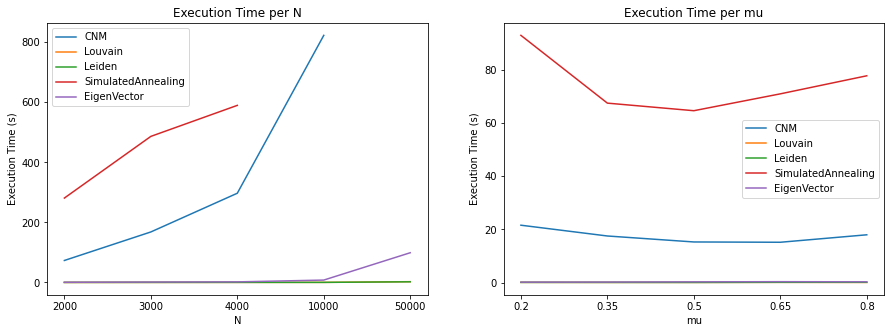

In [86]:
plt.figure("Execution Time")

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

for alg, series in et_n:
    ax[0].plot([x for x, y in series], [y for x, y in series], label=alg)

ax[0].legend()
ax[0].set_title(f"Execution Time per N")
ax[0].set_xlabel("N")
ax[0].set_ylabel("Execution Time (s)")
    
for alg, series in et_mu:
    ax[1].plot([x for x, y in series], [y for x, y in series], label=alg)
    
ax[1].legend()
ax[1].set_title(f"Execution Time per mu")
ax[1].set_xlabel("mu")
ax[1].set_ylabel("Execution Time (s)")

plt.savefig("exec_time.png")
plt.show()
plt.close("Execution Time")